In [1]:
import sys
import os

In [2]:
if 'google.colab' in sys.modules:
    os.system('apt install python3-mpi4py cython3 libxc-dev gpaw-data')
    os.system('pip install --upgrade gpaw pymatgen')

In [3]:
from ase.build import bulk
from ase.atom import Atom
from ase.atoms import Atoms
from gpaw import GPAW, PW
from ase.visualize.plot import plot_atoms
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.rc('figure', figsize=(18,6))
plt.rc('font', size=20)
from ase.eos import EquationOfState

In [6]:
Cufcc = bulk('Cu', 'fcc', a=4., cubic=True)
calc = GPAW(mode=PW(300), xc='PBE', txt='Cufcc.txt',kpts=[5,5,5])
Cufcc.set_calculator(calc)
Cufcc.get_potential_energy()

-12.260425647747788

In [5]:
initialguess = {'bcc': 3.3, 'fcc': 4.0}

In [7]:
kpoints = [1,3,4,5,7,8]
Ekpt = {}

In [8]:
for struc, latpar in initialguess.items():
    structure = bulk('Cu', crystalstructure=struc, a=latpar, cubic=True)
    Ekpt[struc] = np.array([])
    for kpt in tqdm(kpoints):
        calc = GPAW(mode=PW(300), txt='out.txt', xc='PBE',kpts=[kpt,kpt,kpt])
        structure.set_calculator(calc)
        Ekpt[struc]=np.append(Ekpt[struc], structure.get_potential_energy()/structure.get_global_number_of_atoms())

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

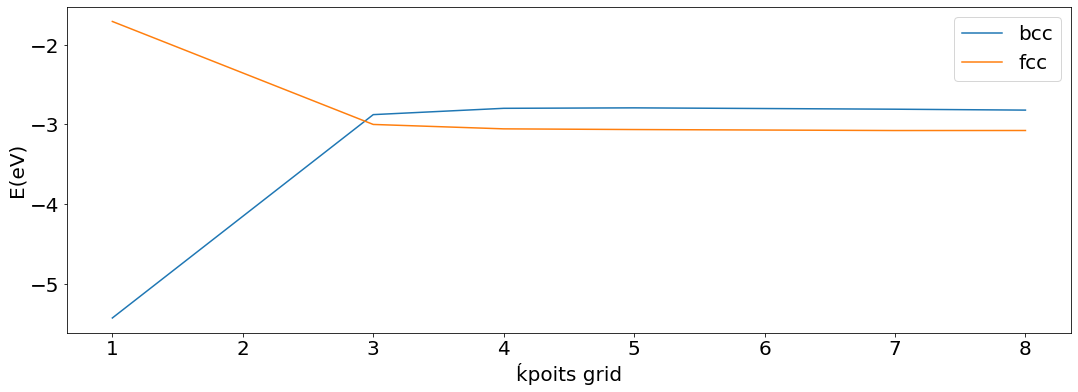

In [9]:
plots = [plt.plot(kpoints, energies, label = struc) for struc, energies in Ekpt.items()]
plt.ylabel('E(eV)')
plt.xlabel('ḱpoits grid')
plt.legend()

In [10]:
KPT= 6

#Cutoff convergence

In [11]:
ecuts = [200, 250, 300, 400, 500,600]
Ecutoff = {}

In [12]:
for struc, latpar in initialguess.items():
    structure = bulk('Cu', crystalstructure=struc, a=latpar, cubic=True)
    Ecutoff[struc] = np.array([])
    for ecut in tqdm(ecuts):
        calc = GPAW(mode=PW(ecut), txt='out.txt', xc='PBE',kpts=[KPT,KPT,KPT])
        structure.set_calculator(calc)
        Ecutoff[struc]=np.append(Ecutoff[struc], structure.get_potential_energy()/structure.get_global_number_of_atoms())

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

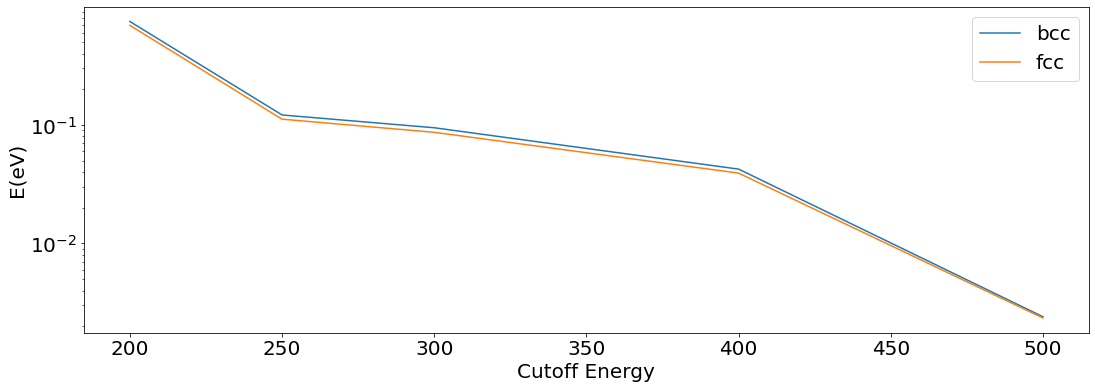

In [14]:
[plt.plot(ecuts[:-1], np.abs((energies[:-1]-energies[-1])/energies[-1]), label = name) for name, energies in Ecutoff.items()]
plt.yscale('log')
plt.ylabel('E(eV)')
plt.xlabel('Cutoff Energy')
plt.legend()

In [15]:
ECUT=450

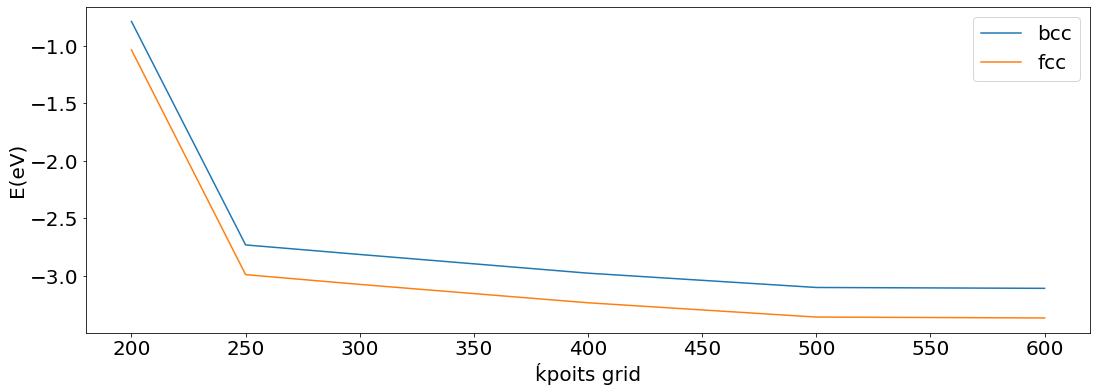

In [13]:
[plt.plot(ecuts, energies, label = struc) for struc, energies in Ecutoff.items()]
plt.ylabel('E(eV)')
plt.xlabel('ḱpoits grid')
plt.legend()

# Lattice Parameter

In [16]:
latparams = {'fcc': np.linspace(2,4,12), 'bcc': np.linspace(2, 4, 12)}

In [17]:
def evcurve(element, structure, sizes, calculator):
    print(f'working on {element} in {structure}')
    structures = []
    E = []
    V = []
    progress = tqdm(sizes)
    for a in progress:
        calc = GPAW(mode=PW(ECUT), xc='PBE', txt=f'{element}{structure}_{a}.txt',kpts=[KPT,KPT,KPT])
        structures.append(bulk(element, structure, a=a, cubic=True))
        structures[-1].set_calculator(calculator)
        E.append(structures[-1].get_potential_energy())
        V.append(structures[-1].get_volume())
    return {'E': E, 'V': V, 'strucs': structures}

In [18]:
evcurves = {struc: evcurve('Cu',struc, thissizes, calc) for struc, thissizes in latparams.items() }

working on Cu in fcc


  0%|          | 0/12 [00:00<?, ?it/s]

working on Cu in bcc


  0%|          | 0/12 [00:00<?, ?it/s]

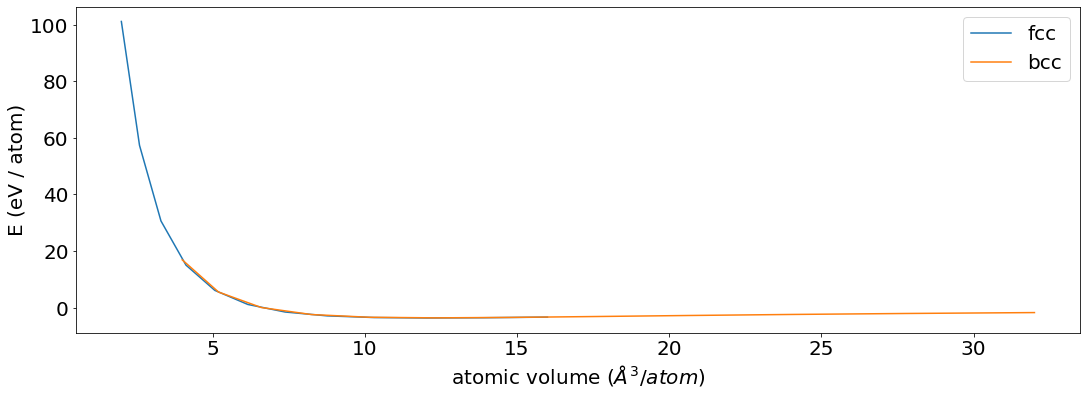

In [19]:
for struc, evcurve in evcurves.items():
    natoms = evcurve['strucs'][-1].get_global_number_of_atoms()
    plt.plot(np.array(evcurve['V'])/natoms,np.array(evcurve['E'])/natoms, label=struc)
plt.legend()
xlabel=plt.xlabel('atomic volume ($\AA ^3 / atom $)')
ylabel = plt.ylabel('E (eV / atom)')

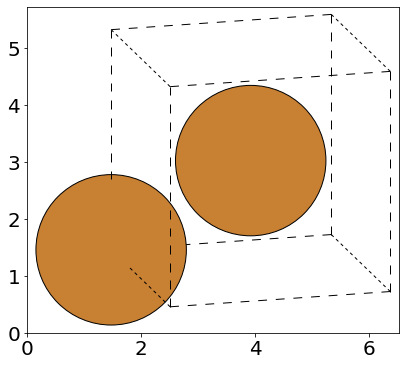

In [20]:
plot_atoms(evcurves['bcc']['strucs'][-1], rotation='15y, 15x')

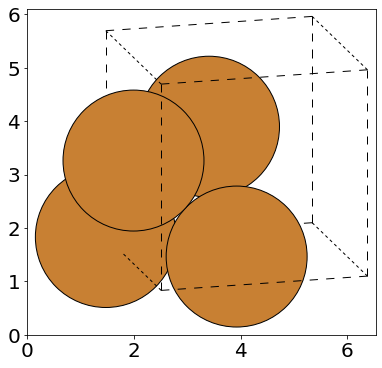

In [21]:
plot_atoms(evcurves['fcc']['strucs'][-1], rotation='15y, 15x')

# Ecuación de estado

In [22]:
eos = EquationOfState(evcurves['fcc']['V'],evcurves['fcc']['E'],eos='birchmurnaghan')

In [23]:
eos.fit()

(44.55086197990586, -15.599338107870352, 1.6875826795112392)

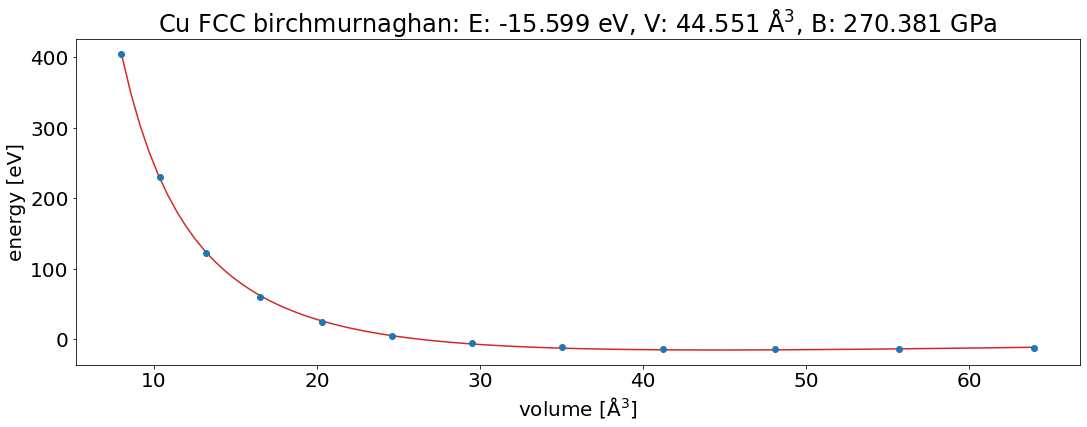

In [24]:
ax = eos.plot()
title = ax.get_title()
newtitle = ax.set_title('Cu FCC ' + title)

In [25]:
eqa = eos.v0**(1/3)

In [27]:
eqa #no me gusta este resultado, da distinto a los que estan en nomad

3.5450201148270404

#Generación de capa

In [28]:
from ase.build import surface, fcc100, fcc110, fcc111, make_supercell

In [29]:
CuMonoLayer = fcc100('Cu',[1,1,1], a=eqa, vacuum=10)

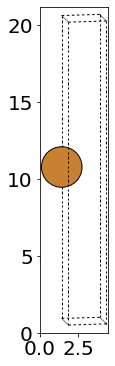

In [30]:
plot_atoms(CuMonoLayer, rotation='90x, 10y, 10x')

In [31]:
CuMonoLayer_2x2 = make_supercell(CuMonoLayer, [[2,0,0],[0,2,0],[0,0,1]])
CuMonoLayer_3x3 = make_supercell(CuMonoLayer, [[3,0,0],[0,3,0],[0,0,1]])
CuMonoLayer_4x4 = make_supercell(CuMonoLayer, [[4,0,0],[0,4,0],[0,0,1]])
CuMonoLayer_5x5 = make_supercell(CuMonoLayer, [[5,0,0],[0,5,0],[0,0,1]])
CuMonoLayer_6x6 = make_supercell(CuMonoLayer, [[6,0,0],[0,6,0],[0,0,1]])

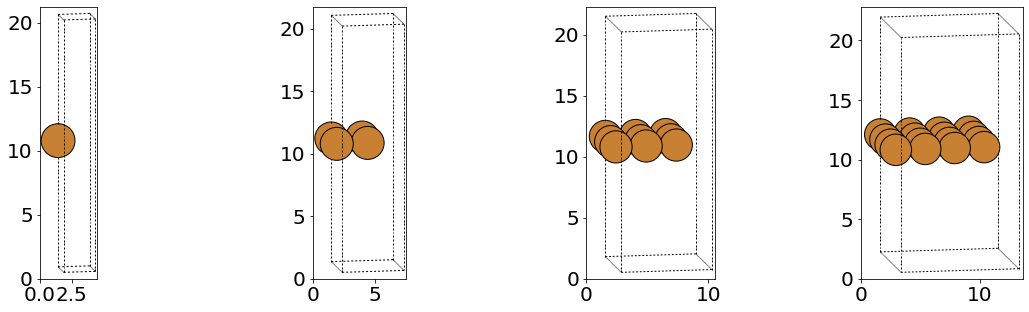

In [32]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
plot_atoms(CuMonoLayer, rotation='90x, 10y, 10x', ax=ax[0])
plot_atoms(CuMonoLayer_2x2, rotation='90x, 10y, 10x', ax=ax[1])
plot_atoms(CuMonoLayer_3x3, rotation='90x, 10y, 10x', ax=ax[2])
plot_atoms(CuMonoLayer_4x4, rotation='90x, 10y, 10x', ax=ax[3])

In [33]:
en_pot100= []

# Monocapa de Cu / [100]

In [34]:
calc = GPAW(mode=PW(ECUT), txt='CuMonolayer.txt', xc='PBE', kpts=[KPT, KPT, 1])
CuMonoLayer.set_calculator(calc)
en_pot100.append(CuMonoLayer.get_potential_energy())

# Binocapa de Cu / [100]

In [35]:
calc = GPAW(mode=PW(ECUT), txt='CuMonolayer_2x2.txt', xc='PBE', kpts=[KPT/2, KPT/2, 1])
CuMonoLayer_2x2.set_calculator(calc)
en_pot100.append(CuMonoLayer_2x2.get_potential_energy())

# Tricapa de Cu

In [36]:
calc = GPAW(mode=PW(ECUT), txt='CuMonolayer_3x3.txt', xc='PBE', kpts=[KPT/3, KPT/3, 1])
CuMonoLayer_3x3.set_calculator(calc)
en_pot100.append(CuMonoLayer_3x3.get_potential_energy())

# Tetra capa Cu

In [37]:
calc = GPAW(mode=PW(ECUT), txt='CuMonolayer_4x4.txt', xc='PBE', kpts=[KPT/4, KPT/4, 1])
CuMonoLayer_4x4.set_calculator(calc)
en_pot100.append(CuMonoLayer_4x4.get_potential_energy())

## Penta capa Cu

In [38]:
calc = GPAW(mode=PW(ECUT), txt='CuMonolayer_5x5.txt', xc='PBE', kpts=[KPT/5, KPT/5, 1])
CuMonoLayer_5x5.set_calculator(calc)
en_pot100.append(CuMonoLayer_5x5.get_potential_energy())

## Hexa Capa Cu

In [39]:
calc = GPAW(mode=PW(ECUT), txt='CuMonolayer_6x6.txt', xc='PBE', kpts=[KPT/6, KPT/6, 1])
CuMonoLayer_6x6.set_calculator(calc)
en_pot100.append(CuMonoLayer_6x6.get_potential_energy())

#Densidad de estado

In [40]:
CuFCC = bulk('Cu', 'fcc', a=eqa)

In [42]:
calc = GPAW(mode=PW(ECUT), xc='PBE', kpts=[15,15,15], txt='equilibrium.txt')
CuFCC.set_calculator(calc)
CuFCC.get_potential_energy()
calcML = GPAW(mode=PW(ECUT), xc='PBE', kpts=[15,15,1], txt='equilibrium.txt')
calcBL = GPAW(mode=PW(ECUT), xc='PBE', kpts=[15/2,15/2,1], txt='equilibrium.txt')
calcTriL = GPAW(mode=PW(ECUT), xc='PBE', kpts=[15/3,15/3,1], txt='equilibrium.txt')
calcTetraL = GPAW(mode=PW(ECUT), xc='PBE', kpts=[15/4,15/4,1], txt='equilibrium.txt')
calcPentaL = GPAW(mode=PW(ECUT), xc='PBE', kpts=[15/5,15/5,1], txt='equilibrium.txt')
calcHexaL = GPAW(mode=PW(ECUT), xc='PBE', kpts=[15/6,15/6,1], txt='equilibrium.txt')
#Monocapa [100]
CuMonoLayer.set_calculator(calcML)
CuMonoLayer.get_potential_energy()
#Bicapa [100]
CuMonoLayer_2x2.set_calculator(calcBL)
CuMonoLayer_2x2.get_potential_energy()
#Tricapa [100]
CuMonoLayer_3x3.set_calculator(calcTriL)
CuMonoLayer_3x3.get_potential_energy()
#Tetra capa [100]
CuMonoLayer_4x4.set_calculator(calcTetraL)
CuMonoLayer_4x4.get_potential_energy()
#Penta capa [100]
CuMonoLayer_5x5.set_calculator(calcPentaL)
CuMonoLayer_5x5.get_potential_energy()
#Hexa capa [100]
CuMonoLayer_6x6.set_calculator(calcHexaL)
CuMonoLayer_6x6.get_potential_energy()


-90.95183639849111

In [43]:
e,dos = CuFCC.calc.get_dos(npts=500)
e2_100, dos_ml_100 = CuMonoLayer.calc.get_dos(npts=500)
e3_100, dos_bl_100 = CuMonoLayer_2x2.calc.get_dos(npts=500)
e4_100, dos_tril_100 = CuMonoLayer_3x3.calc.get_dos(npts=500)
e5_100, dos_tetral_100 = CuMonoLayer_4x4.calc.get_dos(npts=500)
e6_100, dos_pental_100 = CuMonoLayer_5x5.calc.get_dos(npts=500)
e7_100, dos_hexal_100 = CuMonoLayer_6x6.calc.get_dos(npts=500)
ef = CuFCC.calc.get_fermi_level()
efml_100 = CuMonoLayer.calc.get_fermi_level()
efbl_100 = CuMonoLayer_2x2.calc.get_fermi_level()
eftril_100 = CuMonoLayer_3x3.calc.get_fermi_level()
eftetral_100 = CuMonoLayer_4x4.calc.get_fermi_level()
efpental_100 = CuMonoLayer_5x5.calc.get_fermi_level()
efhexal_100 = CuMonoLayer_6x6.calc.get_fermi_level()

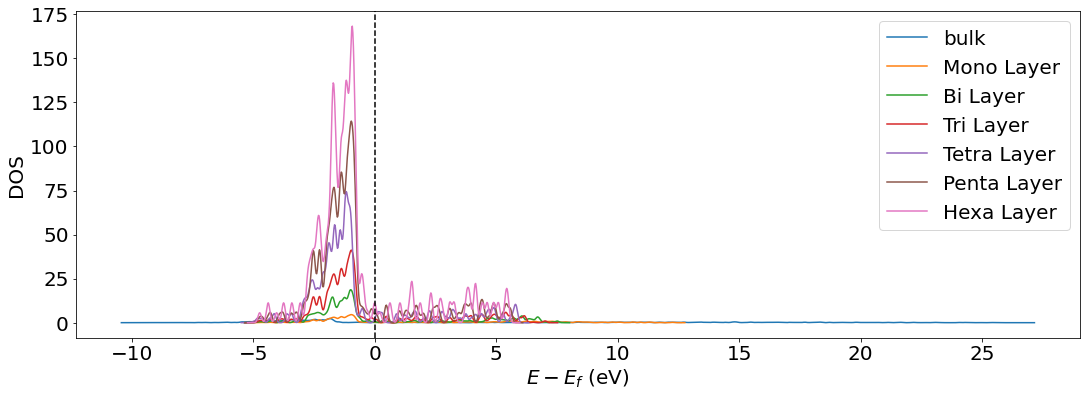

In [44]:
plt.plot(e-ef,dos, label='bulk')
plt.plot(e2_100-efml_100,dos_ml_100, label='Mono Layer')
plt.plot(e3_100-efbl_100,dos_bl_100, label='Bi Layer')
plt.plot(e4_100-eftril_100,dos_tril_100, label='Tri Layer')
plt.plot(e5_100-eftetral_100,dos_tetral_100, label='Tetra Layer')
plt.plot(e6_100-efpental_100,dos_pental_100, label='Penta Layer')
plt.plot(e7_100-efhexal_100,dos_hexal_100, label='Hexa Layer')
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.legend()

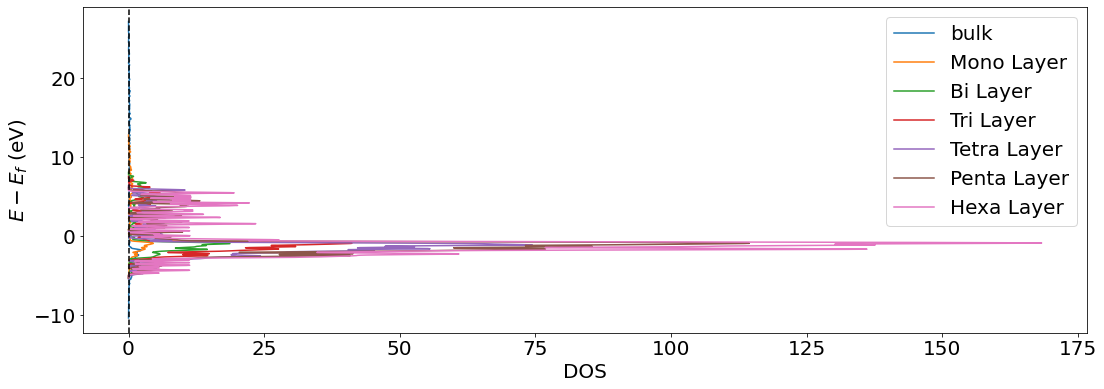

In [45]:
plt.plot(dos,e-ef, label='bulk')
plt.plot(dos_ml_100,e2_100-efml_100, label='Mono Layer')
plt.plot(dos_bl_100,e3_100-efbl_100, label='Bi Layer')
plt.plot(dos_tril_100,e4_100-eftril_100, label='Tri Layer')
plt.plot(dos_tetral_100,e5_100-eftetral_100, label='Tetra Layer')
plt.plot(dos_pental_100,e6_100-efpental_100, label='Penta Layer')
plt.plot(dos_hexal_100,e7_100-efhexal_100, label='Hexa Layer')
plt.axvline(color='k', linestyle='--')
plt.xlabel('DOS')
plt.ylabel('$E - E_f$ (eV)')
plt.legend()

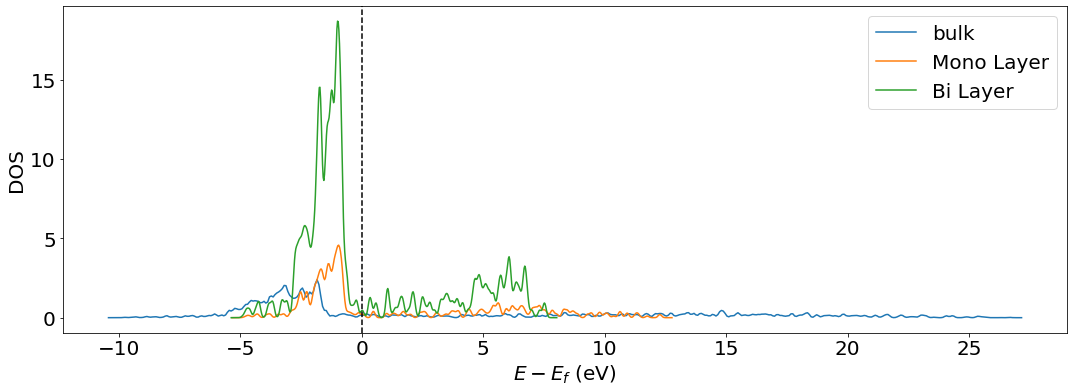

In [47]:
plt.plot(e-ef,dos, label='bulk')
plt.plot(e2_100-efml_100,dos_ml_100, label='Mono Layer')
plt.plot(e3_100-efbl_100,dos_bl_100, label='Bi Layer')
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.legend()